Related urls, will remove once finished:
- https://www.kaggle.com/code/mjmurphy28/grid-search-for-sarima

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima

In [3]:
# Load the dataset
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
data = pd.read_csv(file_path, parse_dates=True)
data = data[[date_column, target_column]]

data.set_index(date_column, inplace=True)
data = data.groupby(date_column).sum().reset_index()



In [4]:
data = data.dropna()
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(data[target_column])

1. ADF :  -2.113417118064879
2. P-Value :  0.23915384830229663
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 1389
5. Critical Values :
	 1% :  -3.4350666494778137
	 5% :  -2.8636230590277587
	 10% :  -2.5678790153478865


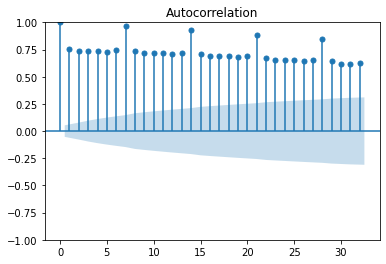

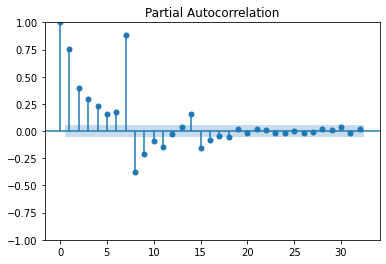

In [5]:
# Plot ACF and PACF for ARIMA order identification
train = data[[target_column]].iloc[:-60]
test = data[[target_column]].iloc[-60:]
plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()

In [6]:
import itertools
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Define the p, d, and q parameters to take any value between 0 and 2
# p = d = q = range(0, 3)

# # Generate all different combinations of p, d, and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, d, and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming a seasonal period of 12

# min_aic = float('inf')
# best_order = None
# best_seasonal_order = None

param_distributions = {
    'order': [(p,d,q) for p in range(3) for d in range(2) for q in range(3)],
    'seasonal_order': [(P,D,Q,s) for P in range(3) for D in range(2) for Q in range(3) for s in [12]] # assuming monthly data
} 
# for order in pdq:
#     for seasonal_order in seasonal_pdq:
#         try:
#             model = SARIMAX(train[target_column], order=order, seasonal_order=seasonal_order)
#             results = model.fit()
#             if results.aic < min_aic:
#                 min_aic = results.aic
#                 best_order = order
#                 best_seasonal_order = seasonal_order
#         except Exception as e:
#             print(e)
#             continue

# print(f"Best ARIMA Order: {best_order}")
# print(f"Best Seasonal Order: {best_seasonal_order}")
sarima = SARIMAWrapper()
tscv = TimeSeriesSplit(n_splits=5)
# Use RandomizedSearchCV
random_search = RandomizedSearchCV(sarima, param_distributions=param_distributions, 
                                   n_iter=10, scoring='neg_mean_squared_error', 
                                   n_jobs=-1, cv=tscv, random_state=42)
# Fit to the data (use only y_train since SARIMA uses the time series itself)
random_search.fit(None, train[target_column])

# Print the best parameters
print('Best order:', random_search.best_params_['order'])
print('Best seasonal order:', random_search.best_params_['seasonal_order'])

NameError: name 'SARIMAWrapper' is not defined

In [7]:
stepwise_fit = auto_arima(data[target_column], trace=True,
suppress_warnings=True, max_P=3, max_D=2, max_Q=3, m=12, stepwise=True)
best_order=stepwise_fit.order
best_seasonal_order=stepwise_fit.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25596.366, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26672.005, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26167.798, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=25765.898, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26670.005, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25619.432, Time=1.49 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=25655.092, Time=1.70 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26560.067, Time=4.69 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25528.197, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=25803.620, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=25489.086, Time=0.81 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=25394.418, Time=1.79 sec
 ARIMA(3,1,2)(2,0

In [8]:
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
GridSearchCV
model=SARIMAX(train[target_column],order=best_order, seasonal_order=best_seasonal_order)
model=model.fit()
model.summary()

c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           New_deaths   No. Observations:                 1347
Model:             SARIMAX(5, 1, 2)x(3, 0, [1], 12)   Log Likelihood              -11747.675
Date:                              Mon, 13 Nov 2023   AIC                          23519.349
Time:                                      21:25:23   BIC                          23581.808
Sample:                                           0   HQIC                         23542.743
                                             - 1347                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0137      0.011      1.272      0.203      -0.007       0.035
ar.L2         -0.7365      0.009    -78.961      0.000      -0.755      -0.718
ar.L3         -0.3734      0.013    -27.980      0.000      -0.400      -0.347
ar.L4         -0.3454      0.009    -39.143      0.000      -0.363      -0.328
ar.L5         -0.7351      0.010    -74.747      0.000      -0.754      -0.716
ma.L1         -0.9807      0.011    -92.320      0.000      -1.002      -0.960
ma.L2          0.6828      0.009     72.075      0.000       0.664       0.701
ar.S.L12       0.6821      0.034     20.162      0.000       0.616       0.748
ar.S.L24      -0.2919      0.027    -10.871      0.000      -0.345      -0.239
ar.S.L36      -0.3070      0.018    -17.034      0.000      -0.342      -0.272
ma.S.L12      -0.2538      0.036     -7.112      0.000      -0.324      -0.184
sigma2      1.176e+06   1.05e+04    112.001      0.000    1.15e+06     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                  26.61   Jarque-Bera (JB):             12700.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\ambro\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

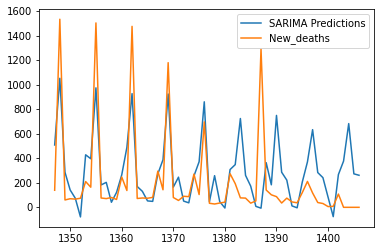

In [9]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('SARIMA Predictions')
pred.plot(legend=True)
test[target_column].plot(legend=True)

In [10]:
test[target_column].mean()
rmse=sqrt(mean_squared_error(pred,test[target_column]))
print(rmse)

305.1154123995522
